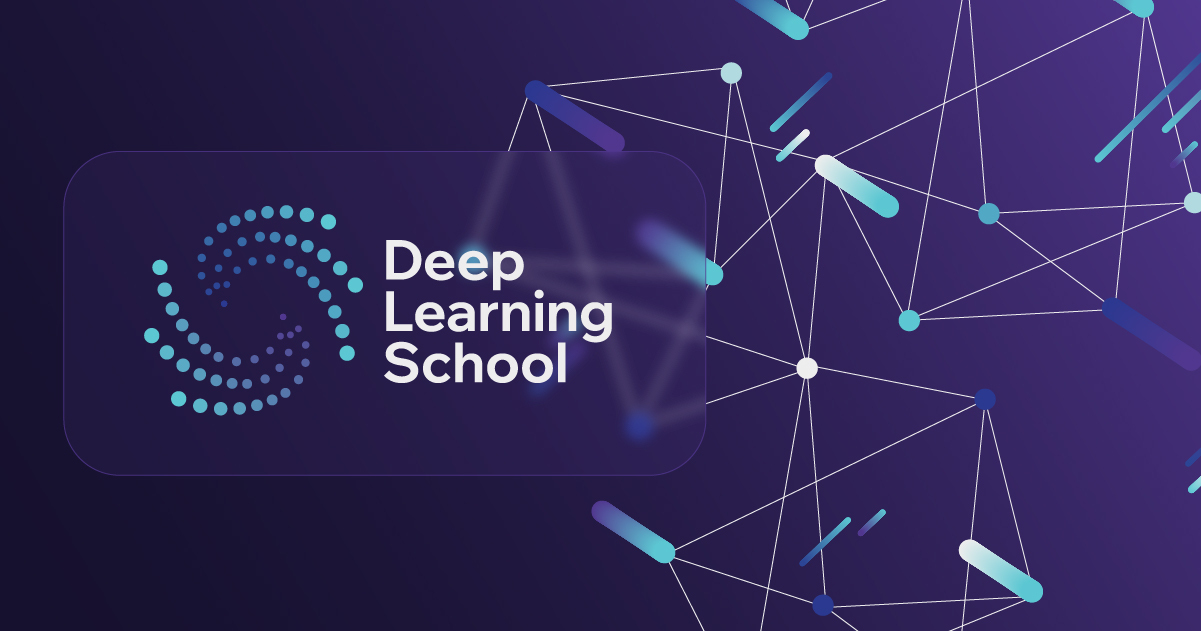

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h1 style="text-align: center;"><b>Семинар. Композиция алгоритмов и выбор модели</b></h1>

В этом семинаре вы узнаете о том, как создаются модели машинного обучения для решения настоящих задач.

# План
1. Напоминание: переобучение, регуляризация и кросс-валидация
  * Синтетический датасет y=2x+3+noise. Используем как линейную, так и полиномиальную зависимости для предсказания
2. Pipeline решения ML задачи
  * Датасет UCI Adult, цель salary > 50K
  * Метрика: ROC-AUC
  * Используемые модели: KNN, Desicion Tree
3. Подбор гиперпараметров и ансамблирование моделей на примере размеченных данных:
    1. Стекинг
      * Используемые модели: KNN, LogReg, Decision Tree и Random Forest с разными гиперпараметрами
    2. Бустинг
      * Используемые модели: XGBoost, CatBoost






In [ ]:
# Установим зависимости. Эти пакеты понадобятся для обучения бустингов.
!pip install xgboost -q
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

from tqdm.notebook import tqdm

# Подготовка данных
from sklearn.preprocessing import StandardScaler

# Оценка моделей
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

# Метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve

# Модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Бустеры
import catboost # документация: https://catboost.ai/docs
import xgboost

# Подавление предупреждений
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

overfitting
многочлены
regularization
cross-validation
pipeline ml задачи
one-hot encoding

# Переобучение и методы борьбы с ним
Переобучение --- это одна из главных проблем, с которыми сталкиваются модели машинного обучения. Эффект переобучения состоит в том, что модель, подстраиваясь под обучающую выборку, "обращает внимание" на закономерности в выборке, которые не проявляются в общем случае и имеют характер совпадения.

Переобучение проявляется тем больше, чем больше степеней свободы имеет модель.
### Примеры:
* Решающее дерево со слишком большой глубиной может идеально подстроиться под обучающую выборку. Параметры решающего дерева --- это решающие правила во всех вершинах (всего $\sim 2^n$ решающих правил в дереве глубины $n$).

* Алгоритм $k$ ближайших соседей подстраивается под обучаюущую выборку и может рассматриваться как эталонный пример переобучения: любой локальный шум в данных приведёт к ошибке. Параметрами Knn являются **все элементы обучающей выборки**.

* Линейный алгоритм, построенный для выборки слишком маленького размера со слишком большим количеством признаков неизбежно переобучится под обучающую выборку.

Во всех примерах мы видим, что при слишком большой сложности модели по сравнению с количеством элементов в обучающей выборке переобучение имеет место. Строго говоря, **переобучение есть всегда, когда имеет место принятие решения в условии неполных данных**, то есть всегда в машинном обучении.

<img src='https://drive.google.com/uc?id=1wQQ0tMAtZVhbeQgUVdiS7kfmMw7P7NM9'/>

Чтобы избежать переобучения, нужно поймать момент, в который качество на тестовой выборке начинает снижаться с ростом сложности модели. В этот момент обучение стоит останавливать.

## Переобучение многочленов
Смоделируем переобучение полиномиальной зависимости с ростом степени многочлена. Сгенерируем искусственные данные из линейной зависимости с шумом и восстановим зависимость с помощью многочленов степени 1, 3, 4, 7.

То есть у нас есть линейная зависимость с некоторым шумом. Мы же будем пытаться аппроксимировать прямую многочленами перечисленных степеней

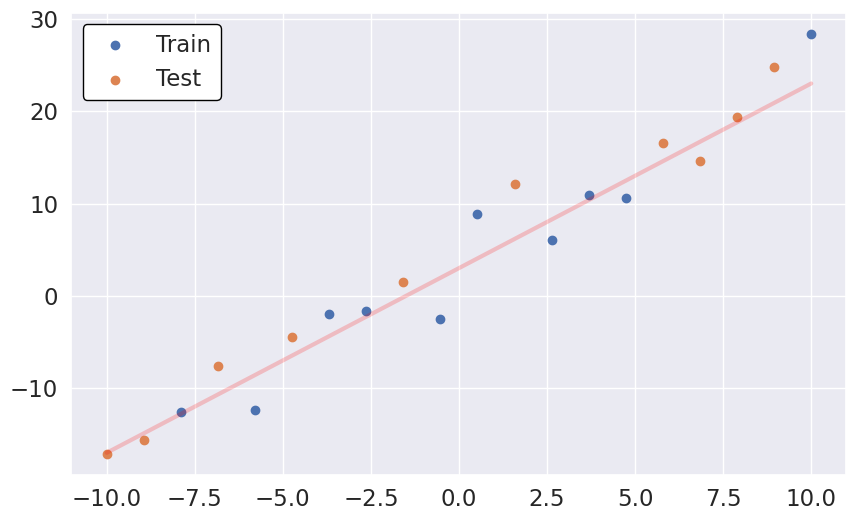

In [ ]:
# Генерируем искусственные данные из линейной зависимости с шумом
X = np.linspace(-10, 10, 20)

y = 2 * X + 3 + np.random.randn(20) * 3

# Разделим данные на обучающие и тестовые данные для контроля переобучения
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
plt.figure(figsize=(10,6))
plt.scatter(X_train,y_train, label='Train')
plt.scatter(X_test,y_test, label='Test')
plt.plot(X, 2 * X + 3, color='red', lw=3, alpha = 0.2)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.show()

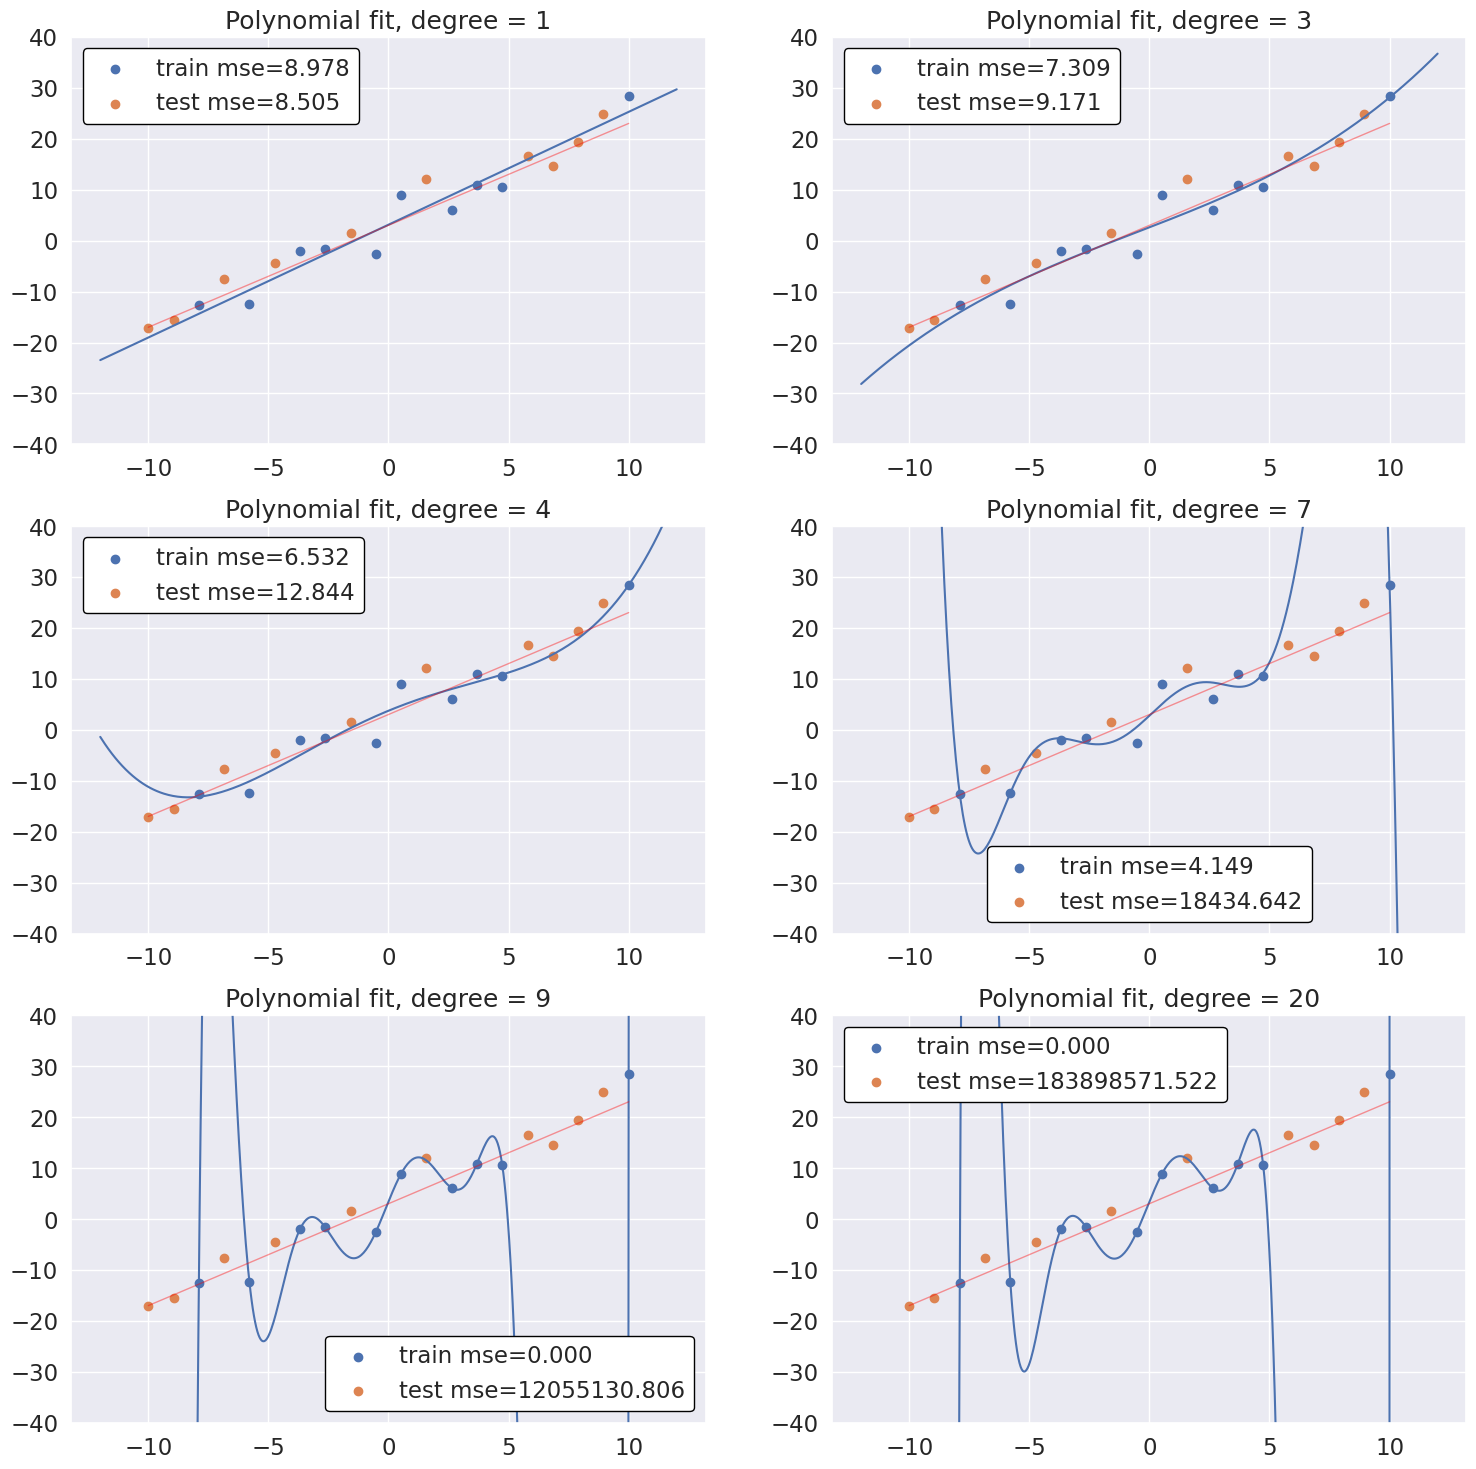

In [ ]:
# Теперь аппроксимируем обучающие данные с помощью полиномов разных степеней
grid = np.linspace(-12, 12, 500)

fig, ax = plt.subplots(3, 2, figsize=(18,18))

ax = ax.ravel()

for i, deg in enumerate([1,3,4,7,9, 20]):

    poly = np.polyfit(X_train, y_train, deg)
    ax[i].set_title('Polynomial fit, degree = ' + str(deg))
    ax[i].scatter(X_train,y_train,
                  label='train mse={:.3f}'.format(mean_squared_error(y_train, np.polyval(poly, X_train))))
    ax[i].scatter(X_test,y_test,
                  label='test mse={:.3f}'.format(mean_squared_error(y_test, np.polyval(poly, X_test))))
    ax[i].set_ylim(-40, 40)
    ax[i].plot(grid, np.polyval(poly, grid))

    ax[i].plot(X, 2 * X + 3, color='red', lw=1, alpha = 0.4)
    legend_box = ax[i].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
fig.show()

**Что такое норма?**\
Нормой (или нормой вектора) называется числовая характеристика, которая определяет "размер" вектора в пространстве. Норма является обобщением понятия длины для векторов в многомерных пространствах.\
В данном случае представлены две формулы для вычисления евклидовой нормы (L2-нормы):

a) Для 2-мерного пространства:
$$||x-y||, \text{x, y - векторы в 2-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + (x_2-y_2)^2}$$


b) Для n-мерного пространства:
$$||x-y||, \text{x, y - векторы в n-мерном пространстве}$$
$$||x - y|| = \sqrt{(x_1 - y_1)^2 + ... + (x_n-y_n)^2}$$

### Идея 1: регуляризация
Суть регуляризации состоит в том, чтобы добавлять к функции потерь слагаемое, ограничивающее рост весов модели. Например, обычная версия линейной регрессии выглядит так:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} \rightarrow \min_{w}.$$

Регуляризованная версия:
$$\frac{\sum\limits_{i=1}^{\ell}\left|\left|\langle x^i, w\rangle - y^i\right|\right|^2}{\ell} + \frac{1}{C}\left|\left|w\right|\right|_2^2\rightarrow \min_{w}.$$

Здесь:

- Первое слагаемое — это сумма квадратов ошибок (MSE).
- Второе слагаемое — это L2-норма вектора весов w, умноженная на коэффициент $\frac{1}{C}\$.

Такая версия линейной регресси называется [**Ridge-регрессией**](https://scikit-learn.ru/stable/modules/kernel_ridge.html).
  
Есть также [**Lasso-регрессия**](https://scikit-learn.ru/stable/modules/linear_model.html#lasso).

Обычная версия логрегрессии:
$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right)\rightarrow \min_{w}$$

Регуляризованная версия:

$$-\frac{1}{\ell}\left( \sum\limits_{y^i = 1}\ln\sigma(\langle x, w\rangle) + \sum\limits_{y^i = -1}\ln(1-\sigma(\langle x, w\rangle))\right) + \frac{1}{C}||w||_1\rightarrow \min_{w}$$
Здесь:

- ∣∣w∣∣ — это L1-норма вектора весов w

<br><br>
и [**ElasticNet**](https://scikit-learn.ru/stable/modules/linear_model.html#elastic-net) - это комбинация L1 и L2-регуляризации.

### Идея 2: кросс-валидация

**Кросс-валидация** (или **перекрёстная проверка**) — это метод оценки производительности и обобщающей способности моделей машинного обучения. Она используется для того, чтобы понять, насколько хорошо модель будет работать на новых, ранее не виденных данных. Кросс-валидация помогает избежать переобучения (overfitting) и более точно оценить качество модели.

**Основная идея**

Данные разбиваются на несколько частей (подмножеств), после чего модель обучается на одной части данных и проверяется на другой. Этот процесс повторяется несколько раз, чтобы каждая часть данных побывала в роли валидационного набора.

<img src='https://drive.google.com/uc?id=19TOWCsLwIjNSmcHzu46f6JqY5TEefm9h' width=600/>

Картинка говорит сама за себя. Чтобы получить более стабильное предсказание и точно увидеть переобучение, можно использовать кросс-валидацию. Это ещё пригодится дальше в ноутбуке.

# Pipeline решения ML-задачи

![lifecycle.png](https://drive.google.com/uc?export=view&id=1ZVVA3knTV7M0sTANYF4kOSMAZWG_BB5j)

![pipeline.jpg](https://drive.google.com/uc?export=view&id=1wt86eJI3wDb4SuRKFdtjvqKDaW0UDLvz)

# Выбор оптимальной модели

Теперь мы потренируемся обучению, оценке и валидации моделей, подбору оптимальных гиперпараметров, смешиванию моделей. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k.

In [ ]:
# Загрузка данных в Пандас с URL
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', sep=', ')

# Назначаем имена колонок
columns = ('age workclass fnlwgt education educ-num marital-status occupation relationship '
           'race sex capital-gain capital-loss  hours-per-week native-country salary')

numeric_indices = np.array([0, 2, 4, 10, 11, 12])
categorical_indices = np.array([1, 3, 5, 6, 7, 8, 9, 13])

df.columns = columns.split() # этот метод разделит датасет по колонкам как в массиве columns (по пробелам)

df = df.replace('?', np.nan) # Заменяем значения '?' на пропуски

df = df.dropna()

df['salary'] = df['salary'].apply((lambda x: x=='>50K')) # Будем предсказывать 1(True), если зарплата больше 50K, 0(False) иначе

In [ ]:
numeric_data = df[df.columns[numeric_indices]]

categorial_data = df[df.columns[categorical_indices]]
categorial_data.head()

,workclass,education,marital-status,occupation,relationship,race,sex,native-country
0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States
1,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States
2,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States
3,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba
4,Private,Masters,Married-civ-spouse,Exec-managerial,Wife,White,Female,United-States


In [ ]:
df['education'].unique(), len(df['education'].unique())

(array(['Bachelors', 'HS-grad', '11th', 'Masters', '9th', 'Some-college',
        'Assoc-acdm', '7th-8th', 'Doctorate', 'Assoc-voc', 'Prof-school',
        '5th-6th', '10th', 'Preschool', '12th', '1st-4th'], dtype=object),
 16)

### One-hot кодирование
Поскольку все алгоритмы машинного обучения, которые мы изучили, работают лишь с числовыми признаками, необходимо придумать способ обработки категориальных признаков, переводящий их в числовые.
Одним из способов сделать это является One-hot кодирование. Его суть состоит в следующем. Пусть некоторая категориальная переменная (скажем, color) принимает $n$ различных значений (Red, Yellow, Green). Тогда можно создать $n$ новыx переменныx, соответствующих различным значениям категориального признака, каждая из которых равна 1 в том случае, если изначальный категориальный признак принимает такое значение, и 0 иначе. Принцип работы иллюстрирован на картинке.

<img src='https://drive.google.com/uc?id=17oipPzKv7JFU5Z94hBUzMb5zJJlpbwxj' width=700/>

В Pandas One-hot кодирование выполняется функцией pd.get_dummies. Сгенерируем One-hot признаки для нашего датасета. Сохраним полную матрицу объекты признаки в переменную X.

In [ ]:
dummy_features = pd.get_dummies(categorial_data, dtype=int)

<span style="color: blue; font-weight: bold"> Замечание : </span>  ❌\
 Метод `pd.get_dummies` применяется скорее при анализе данных. Его стоит крайне осторожно применять в задачах ML, так как в общем случае он не обеспечивает воспроизводимость предобработки новых данных: если применить этот метод по отдельности на двух выборках, наборы сгенерированных one-hot столбцев могут различаться. Если в дальнейшем удалить названия столбцев (например, при конвертации в numpy array), сравнивать разные датасеты станет невозможно.

В ML пайплайнах предобработки данных для кодировки категориальных переменных в реальных задачах используют обучаемые Энкодеры, которые не только сохраняют словарь кодировки и могут работать с данными, в которых другое распределнеие значений в категориях, но и исключают утечку данных между обучающей и тестовой выборками. Кроме того, их обучение можно объединить с обучением моделей в специальных конвеерах (Pipeline), что исключает утечку между выборками даже при кросс-валидации и делает валидацию валидной.

In [ ]:
X = pd.concat([numeric_data, dummy_features], axis=1)
X_origin = df.iloc[:, :-1]
X.head()

,age,fnlwgt,educ-num,capital-gain,capital-loss,hours-per-week,workclass_Federal-gov,workclass_Local-gov,workclass_Private,workclass_Self-emp-inc,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,38,215646,9,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,53,234721,7,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,28,338409,13,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,37,284582,14,0,0,40,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
y = df['salary']

In [ ]:
X.shape, X_origin.shape

((30161, 104), (30161, 14))

Теперь всё готово для обучения алгоритмов.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Откладываем выборку для тестов моделей
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.8,
                                                    random_state=42)

Напишем функцию, визуализирующую поиск оптимального гиперпараметра модели по сетке. Используем идею кросс-валидации.

У нас есть группа гиперпараматров, которые нам нужно подобрать. Для этого мы создаем координатную сетку (с размерностью гиперпараметров), где проходимся по всем возможным комбинациям гиперпараметров, на каждой из которых обучаем модель

После чего мы можем выбрать гиперпараметры лучшей модели. Но вдруг модель переобучится? Поэтому мы используем ```GridSearchCV```, что использует кросс-валидацию

In [ ]:
def search_and_draw(X, y, model, param_name, grid, param_scale='ordinary', draw=True):
    """
    Выполняет поиск по сетке гиперпараметров модели и визуализирует результаты.

    Параметры:
    ----------
    X : array-like of shape (n_samples, n_features)
        Обучающие данные. Матрица признаков.
    y : array-like of shape (n_samples,)
        Целевые значения для обучающих данных.
    model : estimator object
        Экземпляр модели машинного обучения, который будет использоваться для поиска по сетке.
    param_name : str
        Название параметра модели, который будет изменяться в процессе поиска по сетке.
    grid : array-like
        Сетка значений для параметра, который будет исследован.
    param_scale : {'ordinary', 'log'}, optional (default='ordinary')
        Определяет шкалу для оси x на графике. Если 'log', то используется логарифмическая шкала.
    draw : bool, optional (default=True)
        Флаг, указывающий, нужно ли строить график результатов поиска по сетке.

    Возвращает:
    -----------
    means : ndarray of shape (len(grid),)
        Средние значения метрики качества модели для каждого значения параметра из сетки.
    error : ndarray of shape (len(grid),)
        Стандартные отклонения метрики качества модели для каждого значения параметра из сетки.

    Примечания:
    ------------
    Функция использует GridSearchCV для выполнения кросс-валидации с использованием метрики F1.
    Если флаг draw установлен в True, то строится график зависимости среднего значения метрики
    качества модели от значения параметра. На графике также показаны интервалы ошибок.
    """
    # сетку задаем как название параметра: значение, которое может приниматься
    # здесь на вход может приниматься только 1 параметр, иначе нужно умнее инициализировать словарь
    parameters = {param_name: grid}

    CV_model = GridSearchCV(estimator=model,
                            param_grid=parameters, # передаем сетку
                            cv=5, # кросс-валидация, 5 фолдов
                            scoring='f1',  # метрика которая будет отбирать лучшие фолды
                            n_jobs=-1,  # количество параллельных потоков, тут все возможные потоки
                            verbose=10)  # как часто писать логирование

    # раннее создали экземпляр класса, теперь обучаем на данных
    CV_model.fit(X, y)
    means = CV_model.cv_results_['mean_test_score']
    error = CV_model.cv_results_['std_test_score']

    if draw:
        plt.figure(figsize=(15,8))
        plt.title('choose ' + param_name)


        if (param_scale == 'log'):
            plt.xscale('log')

        plt.plot(grid, means, label='mean values of score', color='red', lw=3)

        # средний скор +- 2 отклонения
        plt.fill_between(grid, means - 2 * error, means + 2 * error,
                         color='green', label='filled area between errors', alpha=0.5)
        legend_box = plt.legend(framealpha=1).get_frame()
        legend_box.set_facecolor("white")
        legend_box.set_edgecolor("black")
        plt.xlabel('parameter')
        plt.ylabel('roc_auc')
        plt.show()

    return means, error

Разберем подробнее функцию `search_and_draw` и для чего в ней используется `GridSearchCV`.

**Функция `search_and_draw`**

Эта функция предназначена для автоматизации процесса подбора одного гиперпараметра для заданной модели машинного обучения с использованием кросс-валидации и последующей визуализации результатов.

*   **Входные параметры:**
    *   `X`: Обучающие данные (матрица признаков).
    *   `y`: Целевые значения для обучающих данных.
    *   `model`: Объект модели машинного обучения (например, `KNeighborsClassifier()`, `DecisionTreeClassifier()`).
    *   `param_name`: Строка с названием гиперпараметра, который будет оптимизироваться (например, `'n_neighbors'`, `'max_depth'`).
    *   `grid`: Массив значений, которые будет принимать `param_name` во время поиска.
    *   `param_scale`: Шкала для оси X на графике ('ordinary' или 'log').
    *   `draw`: Флаг, указывающий, нужно ли строить график.

*   **Что делает функция:**
    1.  Создает словарь `parameters` с одним элементом, где ключ - `param_name`, а значение - `grid`. Этот словарь используется `GridSearchCV` для определения сетки параметров для перебора.
    2.  Инициализирует объект `GridSearchCV`.
        *   `estimator=model`: Указывает модель, для которой будут подбираться гиперпараметры.
        *   `param_grid=parameters`: Передает сетку гиперпараметров для поиска.
        *   `cv=5`: Устанавливает количество фолдов для кросс-валидации (в данном случае 5). Данные разбиваются на 5 частей, и модель обучается 5 раз, каждый раз на 4 частях и валидируется на оставшейся. Это помогает получить более надежную оценку качества модели.
        *   `scoring='f1'`: Указывает метрику, по которой будет оцениваться качество модели во время кросс-валидации (здесь используется F1-мера).
        *   `n_jobs=-1`: Позволяет использовать все доступные ядра процессора для ускорения вычислений.
        *   `verbose=10`: Определяет уровень детализации вывода логов в процессе работы.
    3.  Обучает `GridSearchCV` на обучающих данных (`X`, `y`). В процессе обучения `GridSearchCV` перебирает все комбинации гиперпараметров из `param_grid`, для каждой комбинации выполняет кросс-валидацию и вычисляет среднюю оценку качества по выбранной метрике.
    4.  Извлекает средние значения оценок (`mean_test_score`) и стандартные отклонения оценок (`std_test_score`) для каждого значения гиперпараметра из результатов `GridSearchCV`.
    5.  При необходимости (если `draw=True`) строит график, показывающий зависимость среднего значения метрики качества от значения гиперпараметра, а также интервалы ошибок (среднее +/- 2 стандартных отклонения).
    6.  Возвращает средние значения оценок и стандартные отклонения.

**Для чего нужен `GridSearchCV`**

`GridSearchCV` - это инструмент из библиотеки `scikit-learn`, который автоматизирует процесс **подбора оптимальных гиперпараметров** для модели машинного обучения. Он выполняет следующие ключевые функции:

1.  **Систематический перебор:** `GridSearchCV` перебирает все возможные комбинации значений гиперпараметров, заданных в сетке (param_grid). Это гарантирует, что вы исследуете все заданные варианты.
2.  **Кросс-валидация:** Для каждой комбинации гиперпараметров выполняется кросс-валидация. Это помогает получить более надежную оценку качества модели на новых данных, чем простое разбиение на обучающую и тестовую выборки. Кросс-валидация снижает вероятность того, что выбранные гиперпараметры будут оптимальными только для конкретного разбиения данных.
3.  **Оценка качества:** `GridSearchCV` оценивает качество модели для каждой комбинации гиперпараметров с использованием заданной метрики (`scoring`).
4.  **Выбор лучшей модели:** По окончании перебора `GridSearchCV` автоматически определяет комбинацию гиперпараметров, которая дала наилучший средний результат на кросс-валидации, и сохраняет обученную модель с этими гиперпараметрами (если `refit=True`).

Таким образом, `GridSearchCV` избавляет от необходимости вручную писать циклы для перебора гиперпараметров и выполнения кросс-валидации, делая процесс подбора гиперпараметров более эффективным и надежным.

Давайте переберем параметры для KNN и решающего дерева

In [ ]:
models = [KNeighborsClassifier(), DecisionTreeClassifier()]
param_names = ['n_neighbors', 'max_depth'] # первое для KNN, второе для дерева решений
# значения для параметров, 8 разных значений от 4 до 30 (соседи) для 1 параметра и диапазон от 1 до 30 для 2 параметра
grids = [np.array(np.linspace(4, 30, 8), dtype='int'), np.arange(1, 30)]
# по какой шкале абсциссу
param_scales = ['log', 'ordinary']

Fitting 5 folds for each of 8 candidates, totalling 40 fits


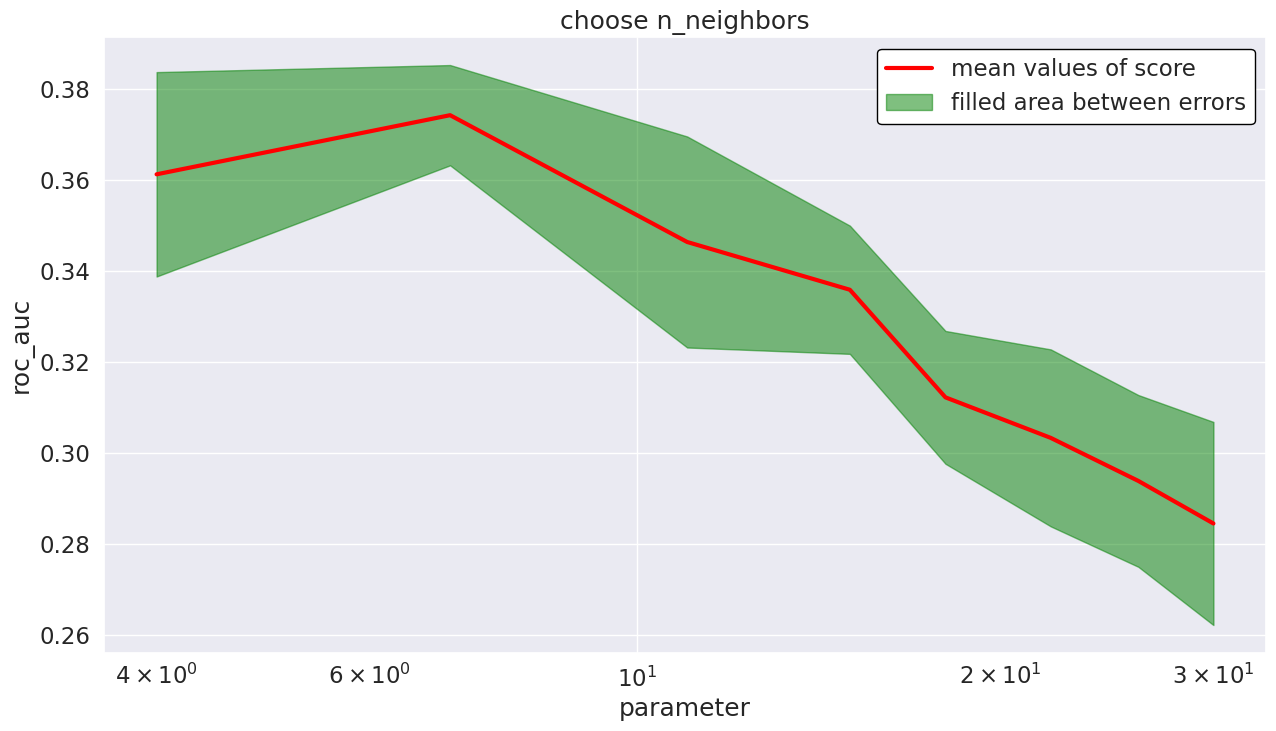

Fitting 5 folds for each of 29 candidates, totalling 145 fits


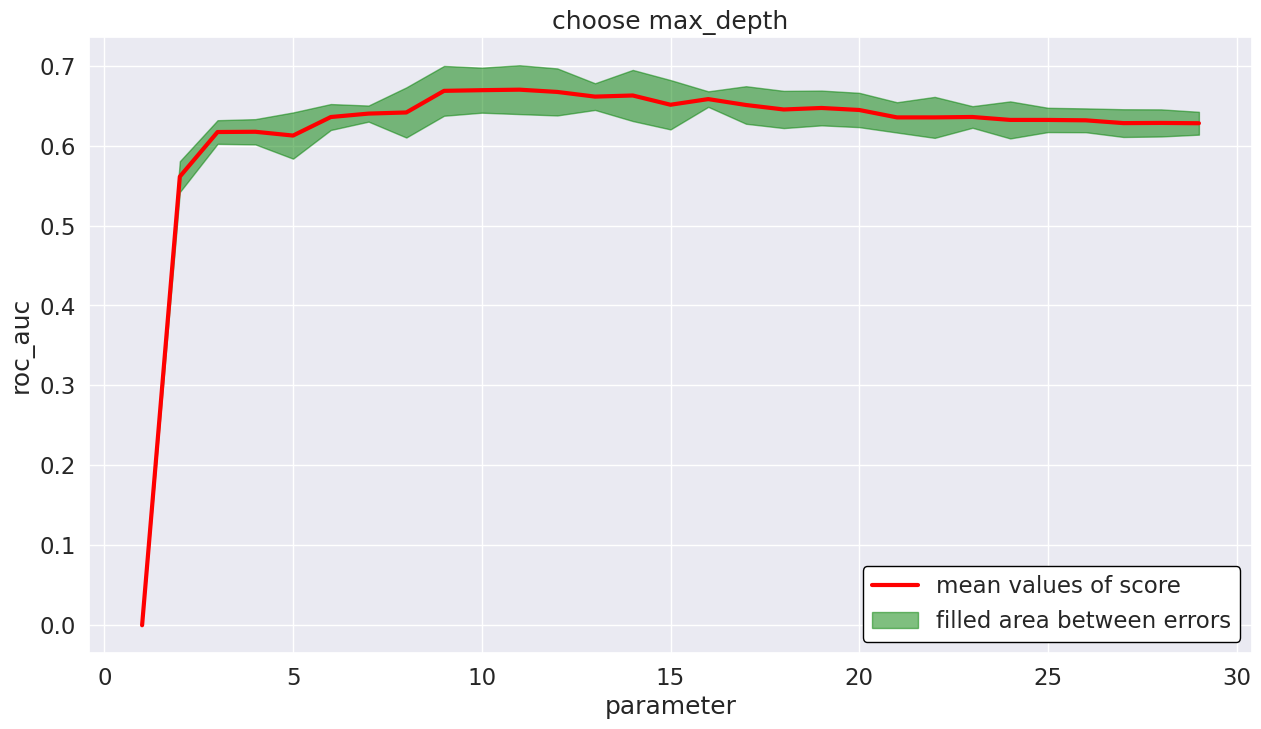

In [ ]:
# zip генерирует попарные кортежи [1, 2, 3] и ['a', 'b', 'c'] => [(1, 'a'), (2, 'b'), (3, 'c')]
for model, param_name, grid, param_scale in zip(models,
                                                param_names,
                                                grids,
                                                param_scales):
    search_and_draw(X_train, y_train, model, param_name, grid, param_scale)

Видим, для 1 графика, что что-то не так и вот почему: Метод k ближайших соседей работает с расстояниями, а они тут не нормированы! Поэтому неэффиктивный алгоритм

А решающее дерево показало себя лучше, и можно подобрать параметр где roc-auc высокий

Поработаем со случайным лесом

Подберём параметр n_estimators в алгоритме случайный лес. Известно, что случайный лес не переобучается. Поэтому график качества будет монотонно возрастать. Следовательно, необходимо найти минимальное значение n_estimators, при котором качество не изменяется.
Поскольку каждое дерево обучается независимо от остальных, достаточно обучить сразу лес из большого количества деревьев, а затем рассмотреть подмножества нужного размера из исходного множества деревьев.

Будем использовать бэггинг, то есть модель случайного леса. Пишем руками, так как проще обучить кучу деревьем и просто брать первые несколько, так как они обучаются независимо. Каждый раз обучаем лес в цикле лес на какаом-то префиксе из деревьев. Случайные леса не склоны к переобучению, поэтому результат ожидается лучше

In [ ]:
max_trees = 100

values = np.arange(max_trees) + 1

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

global_scores = [] # для хранения AUC оценок

for train_indices, val_indices in tqdm(kf.split(X_train), total=5):
    scores = []

    X_train_kf = X_train.iloc[train_indices]
    y_train_kf = y_train.iloc[train_indices]

    X_val_kf = X_train.iloc[val_indices]
    y_val_kf = y_train.iloc[val_indices]


    forest = RandomForestClassifier(n_estimators=max_trees)
    forest.fit(X_train_kf, y_train_kf)
    trees = forest.estimators_

    # Оцениваем модели по сетке параметра.
    for number_of_trees in tqdm(values, leave=False):
        thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)

        thinned_forest.n_classes_ = 2
        thinned_forest.estimators_ = trees[:number_of_trees]

        scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))

    scores = np.array(scores)

    global_scores.append(scores)

global_scores = np.stack(global_scores, axis=0)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Функция выше выполняет подбор гиперпараметра `n_estimators` (количества деревьев) для модели `RandomForestClassifier` с использованием кросс-валидации вручную.

Вот пошаговое описание его работы:

1.  **Инициализация переменных:**
    *   `max_trees = 100`: Задается максимальное количество деревьев, которое будет рассматриваться (до 100).
    *   `values = np.arange(max_trees) + 1`: Создается массив чисел от 1 до 100. Это будут значения `n_estimators`, которые мы будем проверять.
    *   `kf = KFold(n_splits=5, shuffle=True, random_state=1234)`: Создается объект для 5-кратной кросс-валидации. Данные будут случайным образом разбиты на 5 частей (фолдов). `shuffle=True` перемешивает данные перед разбиением, а `random_state` делает разбиение воспроизводимым.
    *   `global_scores = []`: Создается пустой список, в который будут собираться результаты (оценки качества) для каждого фолда кросс-валидации.

2.  **Цикл по фолдам кросс-валидации:**
    *   `for train_indices, val_indices in tqdm(kf.split(X_train), total=5):`: Этот цикл перебирает 5 фолдов. На каждой итерации `kf.split(X_train)` возвращает два массива индексов: `train_indices` для обучающей части текущего фолда и `val_indices` для валидационной части. `tqdm` используется для отображения индикатора прогресса.
    *   `scores = []`: В начале каждого фолда создается временный список `scores` для хранения оценок качества (ROC-AUC) для разного количества деревьев на текущем валидационном фолде.
    *   `X_train_kf = X_train.iloc[train_indices]` и `y_train_kf = y_train.iloc[train_indices]`: Из исходной обучающей выборки `X_train` и `y_train` выбираются строки, соответствующие индексам `train_indices`. Это данные для обучения модели на текущем фолде.
    *   `X_val_kf = X_train.iloc[val_indices]` и `y_val_kf = y_train.iloc[val_indices]`: Выбираются строки для валидации на текущем фолде.
    *   `forest = RandomForestClassifier(n_estimators=max_trees)`: Создается экземпляр модели случайного леса с максимальным количеством деревьев (100).
    *   `forest.fit(X_train_kf, y_train_kf)`: Обучается полный случайный лес на обучающей части текущего фолда.
    *   `trees = forest.estimators_`: Из обученного объекта `forest` извлекается список всех отдельных решающих деревьев.

    То есть здесь реализация кросс-валидации (просто обучаем на 5 фолдах)
3.  **Цикл по количеству деревьев (внутри фолда):**
    *   `for number_of_trees in tqdm(values, leave=False):`: Этот цикл перебирает все значения от 1 до 100 (`values`). `leave=False` скрывает внутренний индикатор прогресса после завершения.
    *   `thinned_forest = RandomForestClassifier(n_estimators=number_of_trees)`: Создается новый экземпляр `RandomForestClassifier`.
    *   `thinned_forest.n_classes_ = 2`: Устанавливается количество классов (для бинарной классификации). Это необходимо, потому что мы вручную будем присваивать деревья модели.
    *   `thinned_forest.estimators_ = trees[:number_of_trees]`: **Важный шаг:** Вместо того чтобы обучать новую модель с `number_of_trees` деревьями с нуля, мы берем первые `number_of_trees` деревьев из уже обученного полного леса (`trees`). Это ускоряет процесс, так как деревья в случайном лесу обучаются независимо.
    *   `scores.append(roc_auc_score(y_val_kf, thinned_forest.predict_proba(X_val_kf)[:, 1]))`: Используя "урезанный" случайный лес (`thinned_forest`), вычисляются вероятности предсказаний для валидационных данных (`X_val_kf`). Затем вычисляется метрика ROC-AUC между истинными метками (`y_val_kf`) и предсказанными вероятностями положительного класса (`[:, 1]`). Эта оценка добавляется в список `scores` для текущего фолда.

    Внутри каждого фолда идет подсчет: гипперпараметр, который мы рассматриваем – это количество деревьев. Поэтому в цикле мы рассматриваем i деревьевот 1 до 100 деревьев и "урезаем" их так, чтобы осталось i деревьев, и для каждого варианта подсчитываем метрику

4.  **Сохранение результатов фолда:**
    *   `scores = np.array(scores)`: Список оценок `scores` для текущего фолда преобразуется в массив numpy.
    *   `global_scores.append(scores)`: Массив оценок текущего фолда добавляется в список `global_scores`, который накапливает результаты по всем фолдам.

5.  **Финальная обработка результатов:**
    *   `global_scores = np.stack(global_scores, axis=0)`: Список массивов оценок из всех фолдов объединяется в один двумерный массив numpy. Теперь `global_scores` имеет размерность (количество фолдов, количество значений n_estimators), где каждая строка соответствует одному фолду, а каждый столбец - определенному количеству деревьев.

Таким образом, этот код выполняет кросс-валидацию для оценки производительности случайного леса с разным количеством деревьев. Он эффективно использует тот факт, что деревья в случайном лесу обучаются независимо, позволяя переиспользовать уже обученные деревья вместо повторного обучения всего леса для каждого значения `n_estimators`. Результаты кросс-валидации затем могут быть использованы для выбора оптимального количества деревьев, которое дает наилучшее качество на валидационных данных.

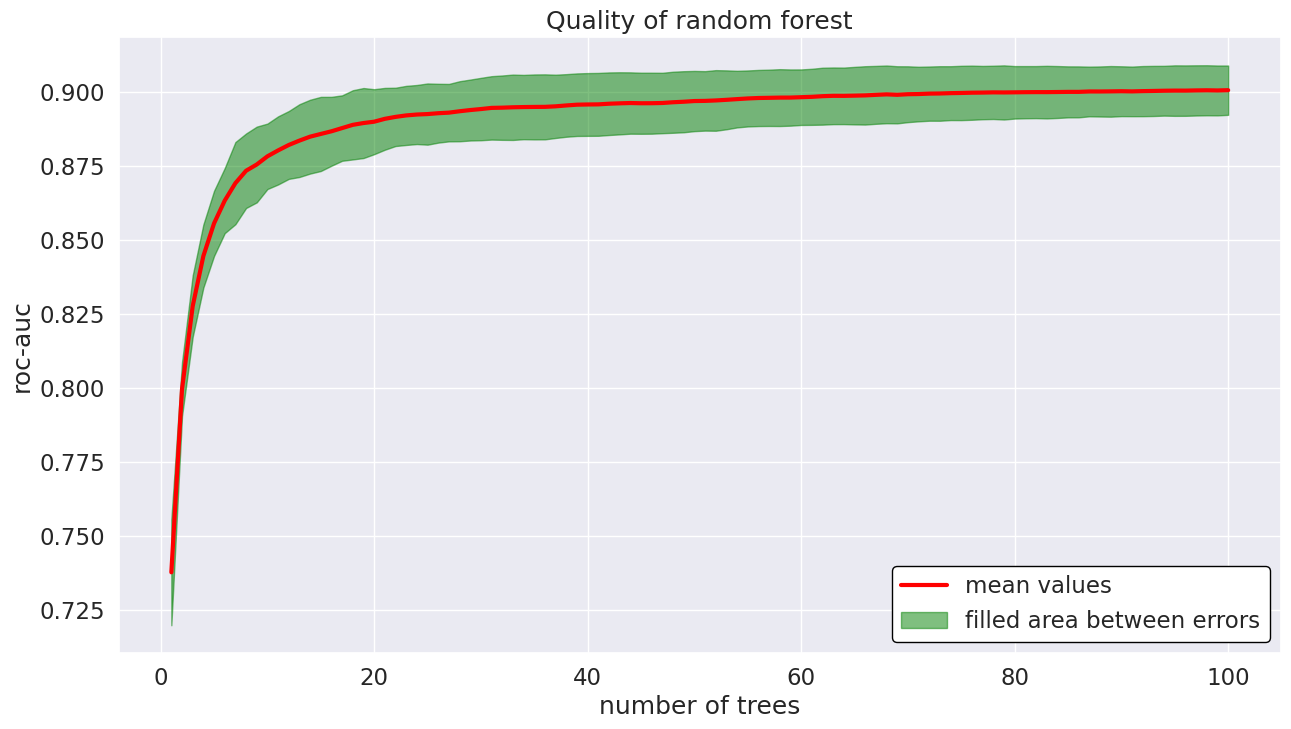

In [ ]:
mean_cross_val_score = global_scores.mean(axis=0)
std_cross_val_score = global_scores.std(axis=0)

plt.figure(figsize=(15,8))
plt.title('Quality of random forest')

plt.plot(values, mean_cross_val_score, label='mean values', color='red', lw=3)
plt.fill_between(values,
                 mean_cross_val_score - 2 * std_cross_val_score,
                 mean_cross_val_score + 2 * std_cross_val_score,
                 color='green',
                 label='filled area between errors',
                 alpha=0.5)
legend_box = plt.legend(framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.xlabel('number of trees')
plt.ylabel('roc-auc')

plt.show()

### Нормировка признаков

Нормируем признаки и проделаем тот же эксперимент с алгоритмом ближайших соседей. Посмотрим, изменилось ли качество предсказания.

In [ ]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<span style="color: blue; font-weight: bold">Замечание: </span>  ❌\
 Здесь `StandardScaler()` обучается на обучающей выборке и масштабирует тестовую используя параметры обучающих данных. Таким образом утечек информации между выборками нет.

Но при кросс-валидации это требование не выполняется, поскольку `StandardScaler()` обучен на всех данных подающихся в кросс-валидацию, без разделения на обучающие и валидационные данные. Чуть ниже добавлен уточненный код для нормировки признаков внутри кросс-валидации.

`StandardScaler` выполняет преобразование $$z = \frac{x - \mu}{\sigma}, \text{где $\sigma$ - стандартное отклонение, а  $\mu$ - среднее}$$

Fitting 5 folds for each of 8 candidates, totalling 40 fits


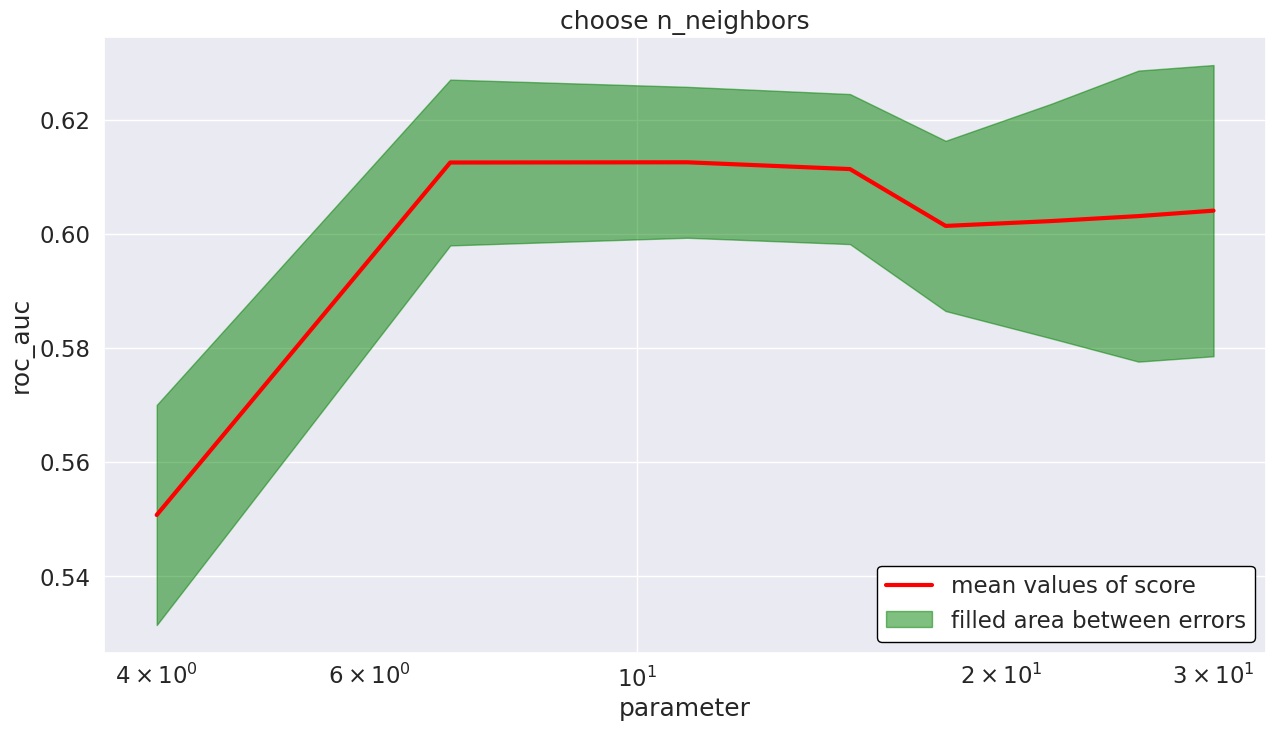

In [ ]:
search_and_draw(X_train_scaled, y_train, KNeighborsClassifier(), 'n_neighbors',
                np.array(np.linspace(4, 30, 8), dtype='int'), 'log');

Ниже представлен уточненный вариант - реализация `StandardScaler()` внутри `GridSearchCV()`. Для этого в нашу функцию `search_and_draw()` в качестве параметра model будем передавать `Pipeline`, объединяющий `StandardScaler()` и `KNeighborsClassifier()`. Про доступ к внутренним параметрам `Pipeline` можно почитать здесь: https://scikit-learn.ru/stable/modules/compose.html#pipeline-nested-parameters (в т.ч. под катом  "Когда это имеет значение?")


Fitting 5 folds for each of 8 candidates, totalling 40 fits


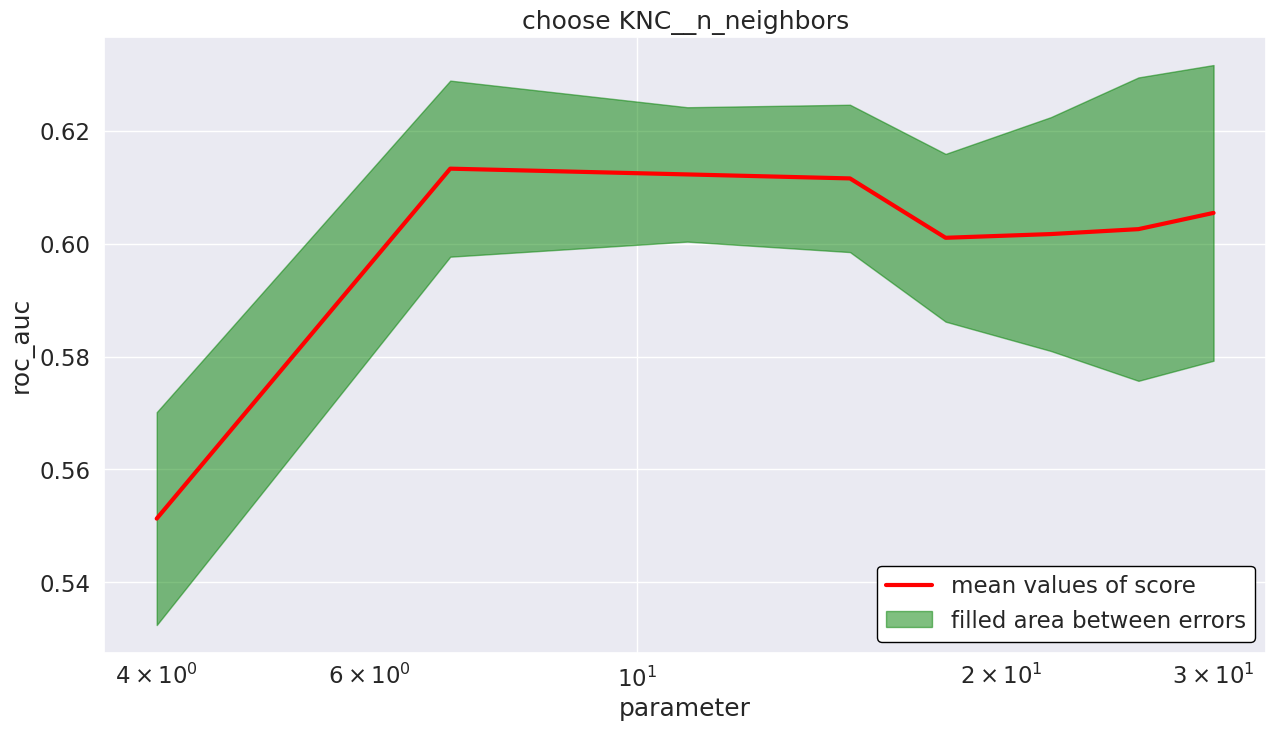

In [ ]:
# Уточненный код. В этом случае предварительное применение StandardScaler() для X_train и X_test не производится
from sklearn.pipeline import Pipeline

pipe_KNC = Pipeline(steps = [('StSc', StandardScaler()), ('KNC', KNeighborsClassifier())])

search_and_draw(X = X_train, y = y_train, model = pipe_KNC, param_name = 'KNC__n_neighbors',
                grid = np.array(np.linspace(4, 30, 8), dtype='int'), param_scale='log');

```Pipeline``` – класс, который позволяет последовательно применять шаги обработки данных и моделирования. Принимает на вход шаги:
1. ```'StSc'``` использует ```StandardScaler()```
2. ```'KNC'``` использует ```KNeighborsClassifier()```

Короче это чето сложное но оно работает и связывается с ```GridSearchCV```, это нужно для предотвращения утечки данных из валидационнной выборки, пока мы обучаем нормировщик

Как и следовало ожидать, ни один из наших алгоритмов не побил случайный лес. Итак, видим, что на больших выборках бэггинг работает. Вычислим итоговое качество на test.

Возьмем 50 деревьев для нашего случайного леса

In [ ]:
model = RandomForestClassifier(n_estimators=50, n_jobs=-1)

model.fit(X_train, y_train)
y_train_predicted = model.predict_proba(X_train)[:, 1]
y_test_predicted = model.predict_proba(X_test)[:, 1]

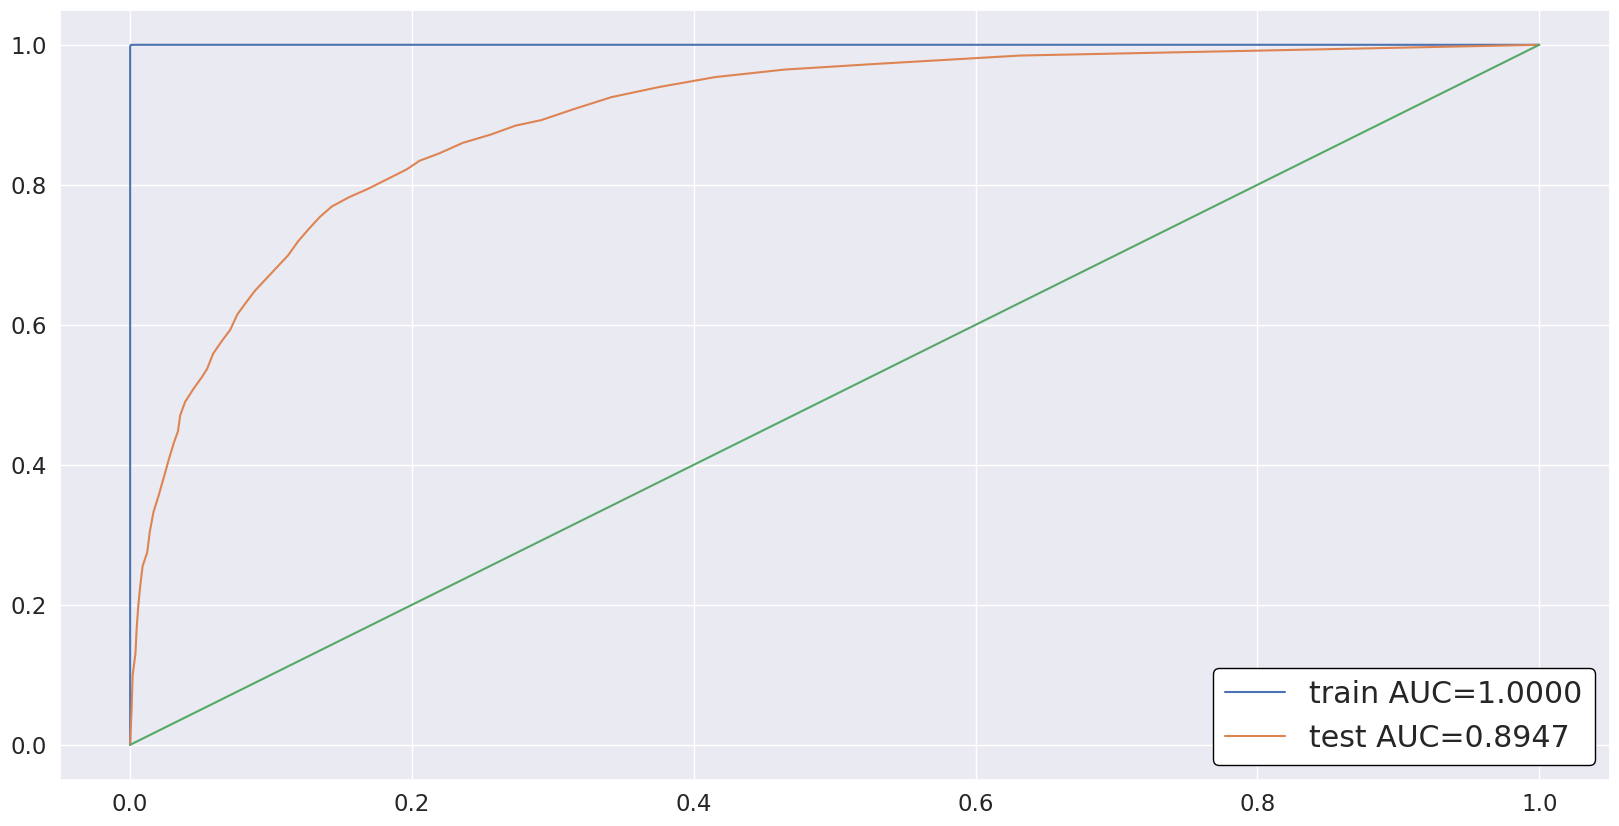

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(20,10))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Качество на train 1, а на тесте 0.89

## Что ещё можно делать:

Мы подбирали оптимальный одномерный параметр для алгоритма. Можно также:

* Искать по сетке не только численные гиперпараметры, но и категориальные, например, метрику в алгоритме ближайших соседей или критерий ветвления в решающем дереве.

* Искать оптимальный параметр по многомерной сетке. Перебрать все возможные варианты здесь не выйдет, потому что на это уйдёт слишком много времени. Зато можно перебирать случайные точки по сетке. Эта процедура называется Grid Random Search.

# Стекинг

Идея стекинга состоит в том, чтобы обучать разнообразные алгоритмы и использовать их в качестве новых признаков объектов.

Чтобы избежать переобучения, необходимо разделить обучающую выборку на n фолдов. Для предсказания ответов на k-ом фолде алгоритм обучается на оставшихся n-1 фолдах и предсказывает ответ на k-ом фолде. Такую схему обучения-предсказания реализует функция sklearn.model_selection.cross_val_predict.

Будем работать с тем же самым датасетом, что и ранее. Посмотрим, сумеем ли мы побить результаты случайного леса с помощью стекинга.

Мета-признаки — это предсказания базовых моделей на обучающей выборке, полученные с помощью кросс-валидации. Мы берем за основу какую-то конкретную модель и проводим кросс-валидацию (например с 5 фолдами): тогда у нас обучается 5 разных экземпляров данной модели. После чего мы смотрим какую вероятность они предлагают при валидации. И таким образом мы и получаем мета-признаки

Мы получаем по сути стек предсказаний для всех элементов изначальной выборки. Ведь 1 экземпляр модели, который валидиируется на 1 фолде дает предсказания по 1 фолду, 2 экземпляр по 2 и тд. И так мы получаем предсказания для всех элементов, сделанных с помощью кросс-валидации

Мета-признаки для тестовой модели – это просто предсказания базовых моделей обученных на всей обучающей выборке (здесь мы не используем кросс-валидацию, а просто обучаем модель на всем обучающем датасете и тестируем на тестовой выборке)

In [ ]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    """
    Вычисляет мета-признаки для стекинга, используя кросс-валидацию и предсказания модели.

    Параметры:
    ----------
    model : estimator object
        Экземпляр модели машинного обучения, которая будет использоваться для вычисления мета-признаков.
    X_train : array-like of shape (n_samples, n_features)
        Матрица признаков обучающей выборки.
    X_test : array-like of shape (n_samples_test, n_features)
        Матрица признаков тестовой выборки.
    y_train : array-like of shape (n_samples,)
        Целевые значения для обучающей выборки.
    cv : int, cross-validation generator or an iterable, optional
        Определяет стратегию кросс-валидации. Может быть целым числом (количество фолдов) или объектом типа кросс-валидатора.

    Возвращает:
    -----------
    train_answers : ndarray of shape (n_samples,)
        Предсказанные вероятности класса для обучающей выборки, полученные с помощью кросс-валидации.
    test_answers : ndarray of shape (n_samples_test,)
        Предсказанные вероятности класса для тестовой выборки, полученные после обучения модели на всей обучающей выборке.

    Примечания:
    ------------
    Функция сначала выполняет кросс-валидацию на обучающей выборке для получения мета-признаков (train_answers).
    Затем модель обучается на всей обучающей выборке, и предсказываются вероятности класса для тестовой выборки (test_answers).
    Если модель не поддерживает метод 'predict_proba', используется метод 'predict' для получения мета-признаков.
    """
    try:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict_proba')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict_proba(X_test)[:, 1]

    except Exception:
        train_answers = cross_val_predict(model, X_train, y_train, cv=cv, method='predict')[:, 1]
        model.fit(X_train, y_train)
        return train_answers, model.predict(X_test)[:, 1]

Собираем в кучу мета-признаки нескольких разных моделей. Это список наших базовых моделей

In [ ]:
models = []
models.append(KNeighborsClassifier(n_jobs=-1, n_neighbors=30))
models.append(LogisticRegression())
models.append(RandomForestClassifier(max_depth=3, n_estimators=50, n_jobs=-1))
models.append(RandomForestClassifier(max_depth=7, n_estimators=50, n_jobs=-1))
models.append(DecisionTreeClassifier(max_depth=8))

In [ ]:
meta_features_train = np.zeros((X_train.shape[0], 0))
meta_features_test = np.zeros((X_test.shape[0], 0))

Вычисляем мета-фичи для наших моделей

In [ ]:
for model in tqdm(models):
    train, test = compute_meta_feature(model, X_train, X_test, y_train, 5)
    # мета-признаки для базовой модели
    meta_features_train = np.append(meta_features_train, train.reshape((train.size, 1)), axis=1)
    # мета-признаки для тестовой модели
    meta_features_test = np.append(meta_features_test, test.reshape((test.size, 1)), axis=1)

  0%|          | 0/5 [00:00<?, ?it/s]

Теперь мы выбираем в качестве главной модели логистическую регрессию, и она будет обучаться на мета-признаках других моделей

In [ ]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_features_train, y_train)

y_train_predicted = stacking_model.predict_proba(meta_features_train)[:, 1]
y_test_predicted = stacking_model.predict_proba(meta_features_test)[:, 1]

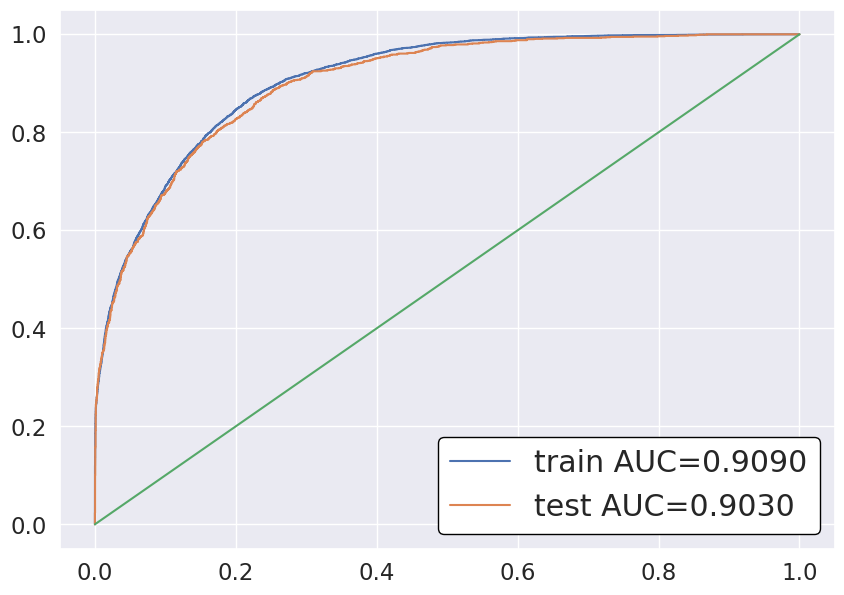

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Раньше было: ```train AUC``` = 1.000, ```test AUC``` = 0.8968, а сейчас стало лучше на тестовой выборке

# Бустинг

Попробуем в пару-тройку строк побить всё то качество, которое мы так усердно искали.

При бустинге мы строим алгоритмы последовательно, а решение выносится взвешенным голосованием

$$ a(x) = c_1a_1(x) + c_2a_2(x) + ... + c_na_n(x)$$

Здесь мы используем градиентный бустинг для решающих деревьев

In [ ]:
# создаем бустинг модель, которая обучается на 500 деревьях
boosting_model = xgboost.XGBClassifier(n_estimators=500)

boosting_model.fit(X_train, y_train)

y_train_predicted = boosting_model.predict_proba(X_train)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test)[:, 1]

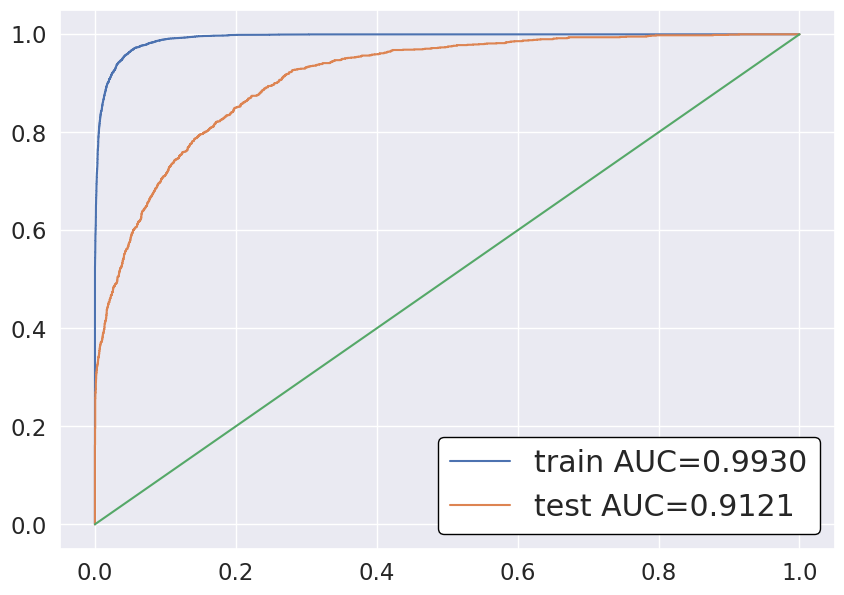

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Круто, да? А теперь попробуем "отечественного" производителя - CatBoost от Яндекса.

In [ ]:
# CatBoost умеет работать с категориальными признаками сам
X_train_origin, X_test_origin, _, _ = train_test_split(X_origin.values, y.values,
                                                       train_size=0.8,
                                                       random_state=42)

![docs_one_hot.png](https://drive.google.com/uc?export=view&id=119U7_cTX8imN13rr3Bi-vevHjo7kEXr6)

(из документации CatBoost)

Не использовать one-hot encoding для категориальных данных


In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200,
                                             cat_features=categorical_indices)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

Learning rate set to 0.175479
0:	learn: 0.5372165	total: 109ms	remaining: 21.7s
1:	learn: 0.4526979	total: 167ms	remaining: 16.5s
2:	learn: 0.4081255	total: 217ms	remaining: 14.3s
3:	learn: 0.3778820	total: 263ms	remaining: 12.9s
4:	learn: 0.3566011	total: 312ms	remaining: 12.2s
5:	learn: 0.3455788	total: 356ms	remaining: 11.5s
6:	learn: 0.3350149	total: 404ms	remaining: 11.1s
7:	learn: 0.3268511	total: 456ms	remaining: 11s
8:	learn: 0.3229313	total: 510ms	remaining: 10.8s
9:	learn: 0.3186000	total: 559ms	remaining: 10.6s
10:	learn: 0.3160912	total: 605ms	remaining: 10.4s
11:	learn: 0.3135176	total: 648ms	remaining: 10.2s
12:	learn: 0.3106304	total: 698ms	remaining: 10s
13:	learn: 0.3088799	total: 744ms	remaining: 9.89s
14:	learn: 0.3069790	total: 792ms	remaining: 9.77s
15:	learn: 0.3054777	total: 840ms	remaining: 9.66s
16:	learn: 0.3045585	total: 893ms	remaining: 9.61s
17:	learn: 0.3026705	total: 947ms	remaining: 9.57s
18:	learn: 0.3018712	total: 1s	remaining: 9.53s
19:	learn: 0.30082

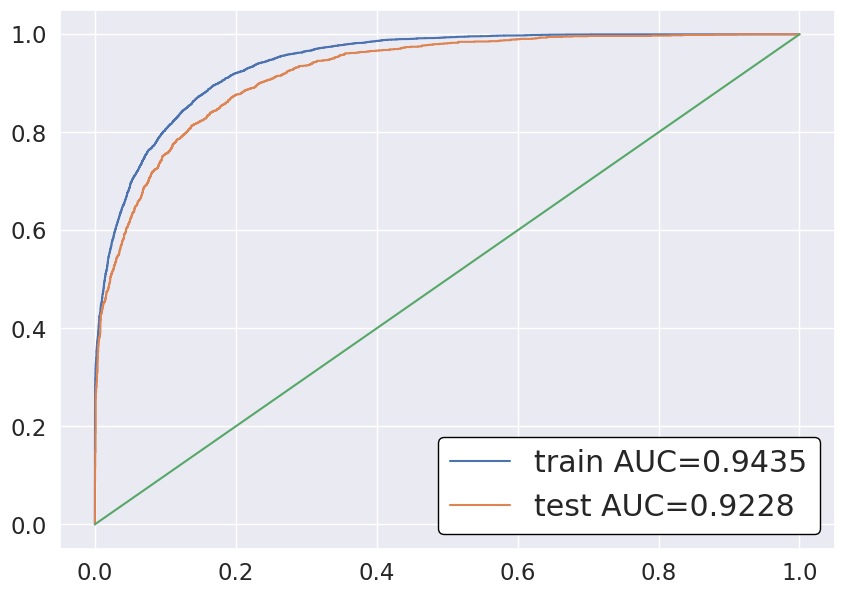

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

In [ ]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, logging_level='Silent',
                                             cat_features=categorical_indices,
                                             eval_metric='AUC')
boosting_model.grid_search({'l2_leaf_reg': np.linspace(0, 1, 20)},
                           X_train_origin,
                           y_train, plot=True, refit=True, verbose=False);

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
Metric AUC is not calculated on train by default. To calculate

In [ ]:
y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_test_predicted = boosting_model.predict_proba(X_test_origin)[:, 1]

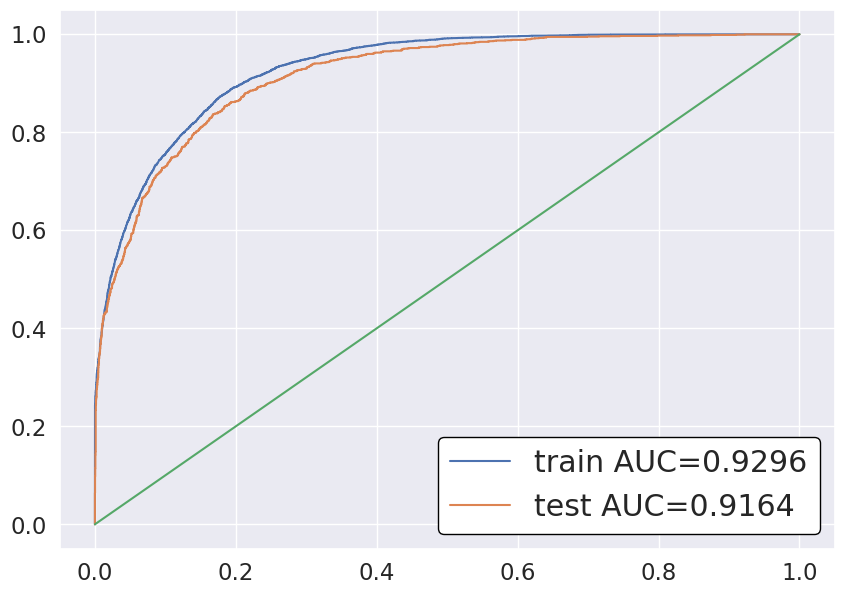

In [ ]:
train_auc = roc_auc_score(y_train, y_train_predicted)
test_auc = roc_auc_score(y_test, y_test_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

# Резюме по занятию.

1. Предобработка данных :
- Были загружены данные из UCI репозитория, содержащие информацию о доходах людей.
- Выполнено разделение признаков на числовые и категориальные, а также проведена обработка пропущенных значений.
- Для категориальных признаков было применено One-hot кодирование, что позволило преобразовать их в числовой формат, необходимый для обучения моделей машинного обучения.
2. Методы борьбы с переобучением :
- Обсуждены основные методы борьбы с переобучением, такие как регуляризация и кросс-валидация.
- Показано влияние степени многочленов на качество модели: слишком высокая степень приводит к переобучению, а низкая — к недообучению.
3. Подбор гиперпараметров :
- Использована кросс-валидация для подбора оптимальных гиперпараметров для нескольких моделей (KNN, решающее дерево, случайный лес).
- Демонстрируется зависимость качества модели от изменения гиперпараметров, таких как количество соседей в KNN или глубина дерева в решающем дереве.
4. Нормировка признаков :
- Применена нормировка признаков для алгоритма ближайших соседей, что значительно улучшило его производительность.
5. Ансамблирование моделей :
- Рассмотрены различные подходы к ансамблированию моделей, такие как стекинг и бустинг.
- Стекинг показал хорошие результаты, но не смог превзойти случайный лес по качеству прогноза.
- Бустинговые модели (XGBoost и CatBoost) продемонстрировали лучшие результаты по сравнению с другими алгоритмами, причём CatBoost особенно выделялся возможностью работы с категориальными признаками без дополнительного кодирования.
## Итоги :
- Наилучшие результаты были достигнуты с использованием бустинговых моделей, которые за счёт последовательного добавления слабых учеников смогли достичь более высокого качества предсказания.
- Ансамблирование моделей является мощным инструментом для улучшения качества прогноза, однако требует тщательной настройки и большого объёма данных для достижения максимальной эффективности.
- Важно помнить о необходимости использования воспроизводимых методов предобработки данных, таких как обучаемые энкодеры, чтобы исключить утечки информации между обучающей и тестовой выборками.